In [13]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import collect_list
from pyspark.sql.types import StructField, StructType, StringType, LongType
import pandas as pd
import numpy as np
from pyspark.ml.feature import RFormula
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel
from pyspark.mllib.evaluation import MulticlassMetrics

In [100]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import StructField, StructType, StringType, LongType
from IPython.display import display_html

spark = SparkSession.builder.appName("final1").config("spark.sql.caseSensitive", "True").getOrCreate()

# Introduction

    In 2021, the top 3 states with the largest number of farms were Texas, Missouri, and Iowa. In 2020, all 3 states voted "red". We wanted to know if the majority of the population/counties in Iowa voted red, or if one party just barely managed to edge out. We want to be able to know if certain counties with more or less farmland vote more red or blue. According to many polls, farmers have tended to lean towards the Reublican party in recent history, so we want to see if there is enough of a presence of farmers in Iowa such that the state is majority red, or if the majority of people there vote for another party. We will further explore the relationship between the ammount of farmland and voting patterns by examining the smallest state in relation to farmland Rhode Island and comparing it to Iowa, the largest farming state.

In [2]:
# Import dataframe 
Iowa = spark.read\
.format("csv")\
.option("header", "true")\
.option("nullValue", "NA")\
.option("delimiter", "\t")\
.option("inferSchema", "true")\
.load("VM2Uniform--IA--2021-03-04.tab")

Iowa.cache()


## Iowa Exploratory Data Analysis 

The only columns we are currently interested in is how each county voted and what the number of votes were. So we subset the necessary columns and drop all others

In [3]:
Iowa_eda = Iowa[['County','Parties_Description']]
Iowa_eda = Iowa_eda.toPandas()

We will now show a graph of the number of counts each major party received. A party is considered major if it received at least one vote in each county. It is a bit hard to tell who exactly has the most votes, so the table below sumarizes which party had the most votes.

<Axes: xlabel='Party'>

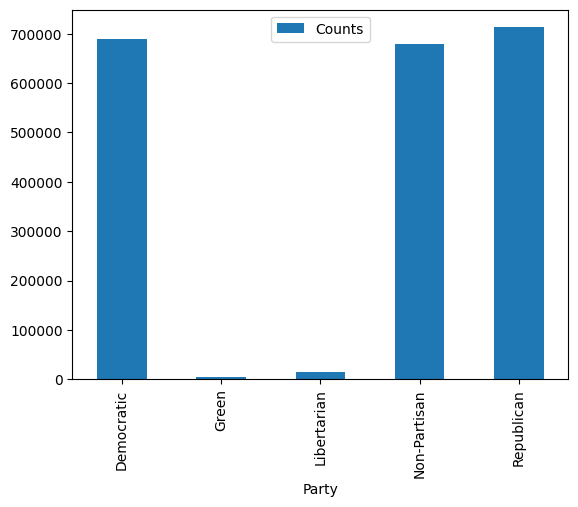

In [4]:
Iowa_PC = Iowa_eda.groupby('Parties_Description').count().reset_index()
Iowa_PC.columns = ['Party', 'Counts']
Iowa_PC.plot(x = 'Party', y = 'Counts', kind = 'bar')

In [5]:
Iowa_eda['Parties_Description'].value_counts().to_frame()

,Parties_Description
Republican,713219
Democratic,689374
Non-Partisan,679490
Libertarian,14416
Green,3859


As we can see, the Republican party got the most votes, but it just barely had more than both the Democratic and Non-Partisan parties

We will now see how each county voted in Iowa. Looking at our initial table, it is a bit hard to tell how each county voted.

In [6]:
Iowa_TCC = Iowa_eda.value_counts().reset_index()
Iowa_TCC.columns = ['County', 'Parties_Description', 'Counts']
Iowa_TCC = Iowa_TCC.sort_values('County')
Iowa_TCC = Iowa_TCC.set_index('County')
Iowa_TCC

,Parties_Description,Counts
County,,
ADAIR,Non-Partisan,1914
ADAIR,Libertarian,23
ADAIR,Green,6
ADAIR,Democratic,1034
ADAIR,Republican,2251
...,...,...
WRIGHT,Libertarian,27
WRIGHT,Green,9
WRIGHT,Democratic,1820


Because the table is hard to read, we will transform the data. The code below makes each county had the respective parties vote count in each column. They were abbreviated as the starting letter(s) of the party and then 'count' after.

In [7]:
Iowa_CC = pd.DataFrame()

Iowa_CC['Rcount'] = Iowa_TCC.loc[Iowa_TCC['Parties_Description'] == 'Republican']['Counts']
Iowa_CC['Dcount'] = Iowa_TCC.loc[Iowa_TCC['Parties_Description'] == 'Democratic']['Counts']
Iowa_CC['NPcount'] = Iowa_TCC.loc[Iowa_TCC['Parties_Description'] == 'Non-Partisan']['Counts']
Iowa_CC['Lcount'] = Iowa_TCC.loc[Iowa_TCC['Parties_Description'] == 'Libertarian']['Counts']
Iowa_CC['Gcount'] = Iowa_TCC.loc[Iowa_TCC['Parties_Description'] == 'Green']['Counts']

Iowa_CC

,Rcount,Dcount,NPcount,Lcount,Gcount
County,,,,,
ADAIR,2251,1034,1914,23,6
ADAMS,1137,550,968,11,2
ALLAMAKEE,4216,2216,2795,38,10
APPANOOSE,3434,2103,2712,44,11
AUDUBON,1978,991,1133,13,3
...,...,...,...,...,...
WINNEBAGO,2990,1739,2692,45,7
WINNESHIEK,4725,4887,4935,53,23
WOODBURY,22646,18781,18249,383,125


Looking at a barplot of how each county voted and how each party did in each county, it is very hard to gather any information from it

<Axes: xlabel='County'>

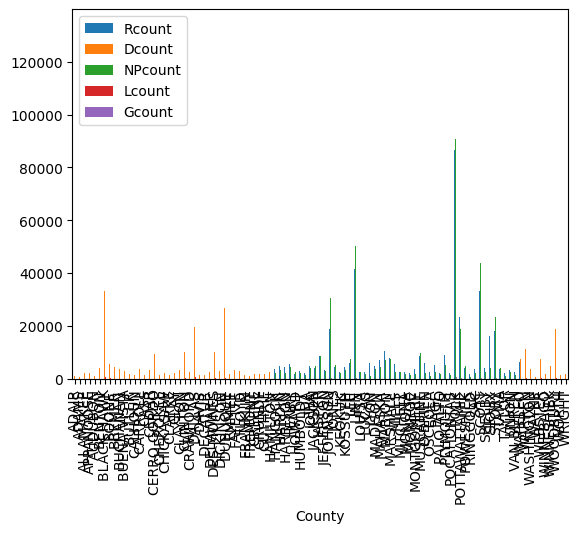

In [8]:
Iowa_CC = Iowa_CC.reset_index()
Iowa_CC.plot(x = 'County', y = ['Rcount','Dcount','NPcount','Lcount','Gcount'], kind = 'bar')

This is because there were so many counties that it is hard to fit it on a graph. In fact, there are 99 counties. Instead we can look at individual graphs. We will take a look at just the Republican and Democratic parties as those were the final contenders in the 2020 election and see if there is a clearly winner in votes

<AxesSubplot:xlabel='County'>

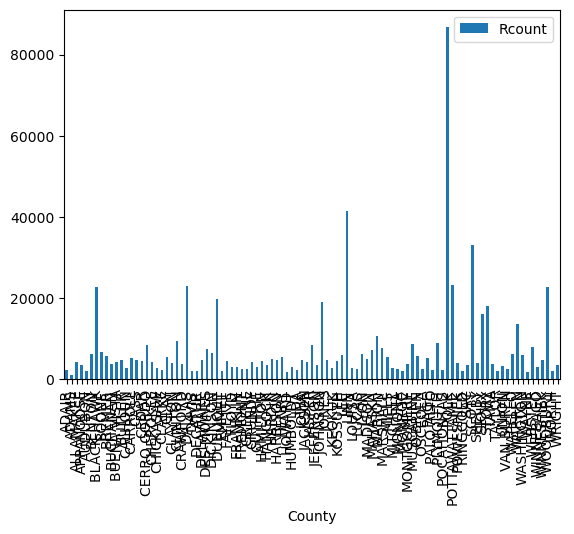

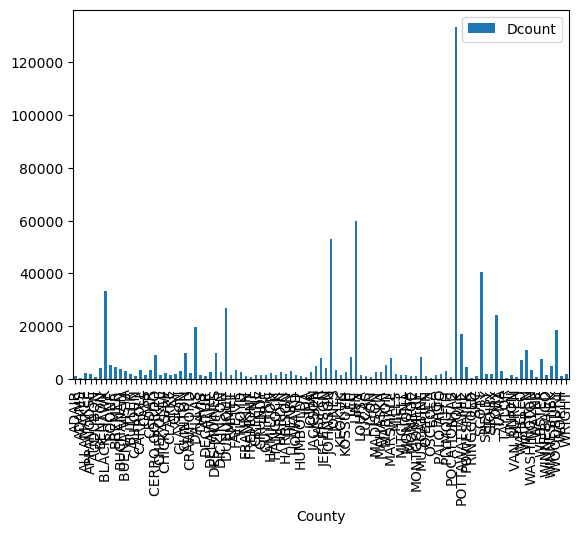

In [31]:
Iowa_R = Iowa_CC[['County','Rcount']]
Iowa_R.plot(x = 'County', y = 'Rcount', kind = 'bar')

Iowa_D = Iowa_CC[['County','Dcount']]
Iowa_D.plot(x = 'County', y = 'Dcount', kind = 'bar')

As we can see, it is still hard to capture all 99 counties in a single graph, but from the general trend of the barplots, they appear similar in shape and count. This suggests that many counties are not voting as a majority for either the Democratic or Republican party. Rather they are split about 50/50. As stated before Iowa ended up voting as a red state, so it seems that altough close, the Republican party managed to edge out a bit more votes to win

For further EDA, we shall take a look at how the other parties did against each other.

<AxesSubplot:xlabel='County'>

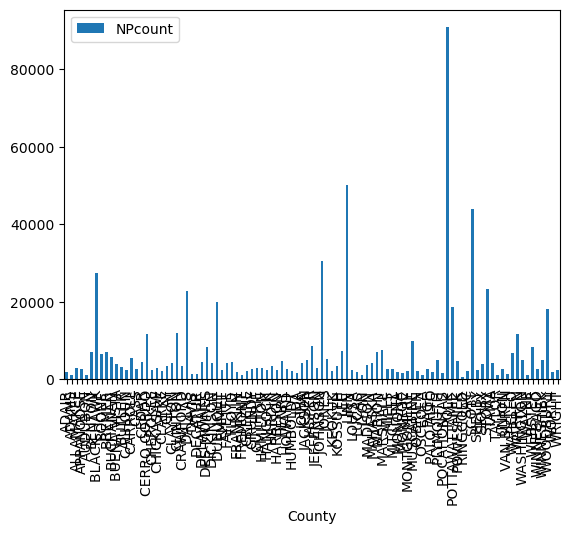

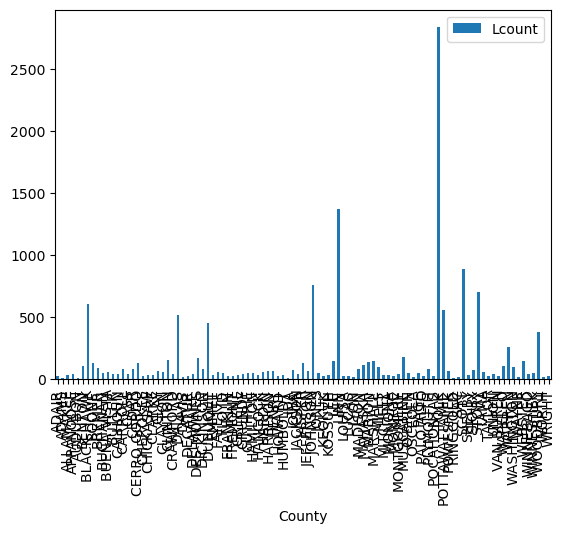

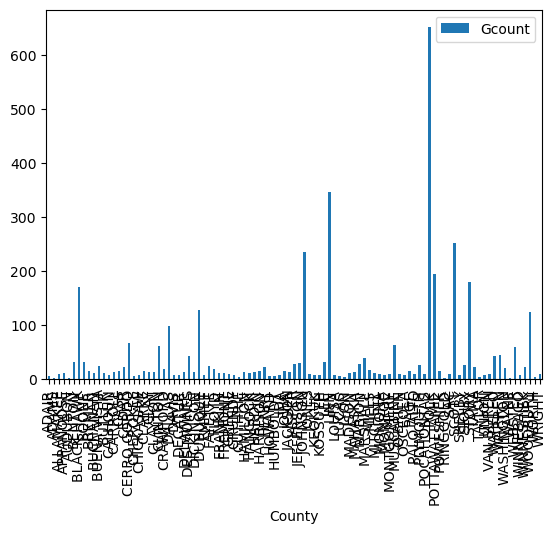

In [32]:
Iowa_NP = Iowa_CC[['County','NPcount']]
Iowa_NP.plot(x = 'County', y = 'NPcount', kind = 'bar')

Iowa_L = Iowa_CC[['County','Lcount']]
Iowa_L.plot(x = 'County', y = 'Lcount', kind = 'bar')

Iowa_G = Iowa_CC[['County','Gcount']]
Iowa_G.plot(x = 'County', y = 'Gcount', kind = 'bar')

Looking at all three of these other parties, we can see that just like the Democratic and Republican party, they have a similar trend in shape, but not numbers. The Green Party, bottom graph, had such small count numbers on the y-axis. In fact, they received less than 4,000 votes. The Libertarian party also received a small proportion of total votes. It had less than 15,000 votes. The Non-Partisan party, however, received almost as many votes as the Democratic party. This clearly shows that each county did not vote for a majority at all. It was a close 3 way tie between the Republican, Democratic, and Non-Partisan party. It seems that Iowa just barely managed to vote red.

### Conclusion

Our EDA into Iowa's voting habits shows us that although Iowa voted red in the 2020 election, there is no majority party that the people voted for. Rather, the number of votes between the Democratic, Republican, and Non-Partisan party was very close. Each party differed by only a couple thousan votes. The smaller Libertarian and Green party had around 20,000 votes combined which could have swing the vote for a party. Those 20,000 votes could easily guarantee a party having the majority vote. It will be interesting to see what Texas's and Missouri's voting habits will look like. It is possible that the smaller parties don't have as much of a presence and so there is a clear winner in votes. It could also be similar where the vote difference between the largest parties is possibly even only a couple hundred. In the end we can conclude that just because Iowa is a farming state does not mean it is a majority Republican state.

## Iowa Further Analysis 

The first step in our analysis is to choose the variables we want to explore . Below is the resulting dataframe we will be using after it is cleaned. 

In [85]:
# choose variables to include in dataframe 
Iowa_df = Iowa[['County',
             'Parties_Description',
             "Residence_Addresses_Property_LandSq_Footage",
             "Residence_Addresses_Property_HomeSq_Footage",
             "Voters_Gender",
             'CommercialData_Education',
             'CommercialData_EstimatedAreaMedianHHIncome',
             'CommercialData_EstimatedHHIncome',
             "CommercialData_AreaMedianHousingValue"]]

# transform to pandas dataframe 
Iowa_df = Iowa_df.toPandas()


In [86]:
# rename columns 
Iowa_df = Iowa_df.rename(columns = {"Residence_Addresses_Property_LandSq_Footage" : "Property_LandSq_Footage",
                                      "Residence_Addresses_Property_HomeSq_Footage" : "Property_HomeSq_Footage",
                                      "CommercialData_Education" : "Education",
                                      "CommercialData_AreaMedianEducationYears" : "AreaMedianEducationYears",
                                      "CommercialData_EstimatedAreaMedianHHIncome" : "EstimatedAreaMedianHHIncome",
                                      "CommercialData_EstimatedHHIncome" : "EstimatedHHIncome",
                                      "CommercialData_AreaMedianHousingValue" : "AreaMedianHousingValue"})


## Data Cleaning

 Now that we have chosen the variables we will work with we proceed with data cleaning. Below is the ammount of missing data in each variable of our dataframe

In [87]:
Iowa_clean = Iowa_df

# percentage of data missing for each variable
percent_missing = Iowa_df.isnull().sum() * 100 / len(Iowa_df)

percent_missing


County                          0.000000
Parties_Description             0.000000
Property_LandSq_Footage        16.660255
Property_HomeSq_Footage        18.341540
Voters_Gender                   0.000000
Education                      29.684130
EstimatedAreaMedianHHIncome     3.614241
EstimatedHHIncome               2.586416
AreaMedianHousingValue          3.619193
dtype: float64

    The EstimatedAreaMedianHHIncome and EstimatedHHIncome and AreaMedianHousingValue variables have a very low proportion of missing values.We can proceed by changing the variable types from object to float and factor and proceed by filling in the data using the fillna method. 

In [88]:

# remove dollar signs from estimated median household income and area median housing value and convert to numeric
Iowa_clean["EstimatedAreaMedianHHIncome"] = Iowa_clean["EstimatedAreaMedianHHIncome"].str.replace("$"," ")
Iowa_clean["AreaMedianHousingValue"] = Iowa_clean["AreaMedianHousingValue"].str.replace("$"," ")


# change types of variables 
Iowa_clean["EstimatedAreaMedianHHIncome"] = pd.to_numeric(Iowa_clean["EstimatedAreaMedianHHIncome"])
Iowa_clean["AreaMedianHousingValue"] = pd.to_numeric(Iowa_clean["AreaMedianHousingValue"])

# Change types of Education and EstimatedHHIncome variables 
CleanUp = {'Education':{
    np.nan: 1, 'Less than HS Diploma - Ex Like': 2, 'Less than HS Diploma - Likely': 3, 
    'HS Diploma - Likely': 4,'HS Diploma - Extremely Likely': 5, 
    'Vocational Technical Degree - Extremely Likely':5,
    'Some College - Likely': 6, 'Some College -Extremely Likely': 7, 
    'Bach Degree - Likely': 8, 'Bach Degree - Extremely Likely': 9, 'Grad Degree - Likely': 10, 
    'Grad Degree - Extremely Likely': 11
},

'EstimatedHHIncome':{
    '$1000-14999': 1, '$15000-24999': 2, '$25000-34999':3, '$35000-49999':4,
    '$50000-74999': 5, '$75000-99999': 6, '$100000-124999': 7, '$125000-149999': 8,
    '$150000-174999': 9, '$175000-199999': 10, '$200000-249999': 11, '$250000+': 12
}

}

Iowa_clean = Iowa_df.replace(CleanUp)

Iowa_clean.head()


C:\Users\pchu1\AppData\Local\Temp\ipykernel_14308\3847562280.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Iowa_clean["EstimatedAreaMedianHHIncome"] = Iowa_clean["EstimatedAreaMedianHHIncome"].str.replace("$"," ")
C:\Users\pchu1\AppData\Local\Temp\ipykernel_14308\3847562280.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  Iowa_clean["AreaMedianHousingValue"] = Iowa_clean["AreaMedianHousingValue"].str.replace("$"," ")


,County,Parties_Description,Property_LandSq_Footage,Property_HomeSq_Footage,Voters_Gender,Education,EstimatedAreaMedianHHIncome,EstimatedHHIncome,AreaMedianHousingValue
0,ADAIR,Democratic,342000.0,3500.0,F,1,66266.0,5.0,104166.0
1,ADAIR,Non-Partisan,342000.0,3500.0,M,1,66266.0,5.0,104166.0
2,ADAIR,Non-Partisan,1698000.0,1600.0,F,6,66266.0,5.0,104166.0
3,ADAIR,Non-Partisan,50000.0,2300.0,F,9,66266.0,2.0,104166.0
4,ADAIR,Democratic,1555000.0,2800.0,F,4,69948.0,6.0,91666.0


In [89]:
# fill missing values with mean of each column
Iowa_clean["EstimatedAreaMedianHHIncome"] = Iowa_clean["EstimatedAreaMedianHHIncome"].fillna(Iowa_clean["EstimatedAreaMedianHHIncome"].mean())
Iowa_clean["AreaMedianHousingValue"] = Iowa_clean["AreaMedianHousingValue"].fillna(Iowa_clean["AreaMedianHousingValue"].mean())

# Fill EstimatedHHIncome using the median 
Iowa_clean["EstimatedHHIncome"] = Iowa_clean["EstimatedHHIncome"].fillna(Iowa_clean["EstimatedHHIncome"].median())


In [90]:
# Keep only the rows with at least 8 non-NA values.
Iowa_clean = Iowa_clean.dropna(thresh = 8)


In [91]:
# Only 1.1% and 3.09% is missing for Land square footage and home square footage respectively so fill in with mean 
Iowa_clean["Property_LandSq_Footage"] = Iowa_clean["Property_LandSq_Footage"].fillna(Iowa_clean["Property_LandSq_Footage"].mean())
Iowa_clean["Property_HomeSq_Footage"] = Iowa_clean["Property_HomeSq_Footage"].fillna(Iowa_clean["Property_HomeSq_Footage"].mean())

Iowa_clean.isnull().sum() * 100 / len(Iowa_clean)

County                         0.0
Parties_Description            0.0
Property_LandSq_Footage        0.0
Property_HomeSq_Footage        0.0
Voters_Gender                  0.0
Education                      0.0
EstimatedAreaMedianHHIncome    0.0
EstimatedHHIncome              0.0
AreaMedianHousingValue         0.0
dtype: float64

    Our dataset is now clean 

## Comparing Counties - Property Size

    In the following part of our analysis we will conduct a comparison of counties. The purpose of this comparison will be to identify different voting patterns in counties where voters have larger properties versus counties were voters have smaller properties. As stated in our introduction it is our assumption that individuals with larger properties, like farmers, tend to lean toward the Republican party. The comparison will be based on the median property land square footage for each County.

In [92]:
# group by county and calculate median property square footage 

Iowa_grouped = Iowa_clean.groupby(by = ["County"]).aggregate({'Property_LandSq_Footage':'median'})

# Sort by descending order and reset index
Iowa_grouped = Iowa_grouped.sort_values(by = 'Property_LandSq_Footage', ascending = False).reset_index()

Iowa_grouped

,County,Property_LandSq_Footage
0,RINGGOLD,489000.0
1,MADISON,126000.0
2,DAVIS,98000.0
3,ADAMS,87000.0
4,VAN BUREN,82000.0
...,...,...
94,POLK,10000.0
95,BLACK HAWK,10000.0
96,SCOTT,9000.0
97,WOODBURY,9000.0


In [93]:
# assign top 5 and bottom 5 county names
top = ["RINGGOLD", "MADISON", "VAN BUREN", "DAVIS", "ADAMS"]
bottom = ["POLK","BLACK HAWK","SCOTT", "CERRO GORDO","WOODBURY"]


#return top 5 and bottom 5 counties in terms of square footage from clean dataframe 
top5_df = Iowa_clean[Iowa_clean["County"].isin(top)].round(0)

bottom5_df = Iowa_clean[Iowa_clean["County"].isin(bottom)].round(0)


    We have now extracted the data for the top and bottom 5 counties in terms of property land square footage per voter. We proceed by creating a table containing the voting pattern for each group including the proportion of votes each party has acucumulated. 

In [94]:
#Top 5 counties in land square footage voting patterns 

top5_voting_pattern = top5_df['Parties_Description'].value_counts().to_frame()

# add a proportion column that indicates the proportion of votes for each party
top5_voting_pattern["Proportion"] = top5_voting_pattern["Parties_Description"] / top5_voting_pattern["Parties_Description"].sum()
top5_voting_pattern = top5_voting_pattern.rename(columns = {"Parties_Description" : "Number of Votes"}).style.set_caption("Top 5 Counties - Vote Counts")

top5_voting_pattern


,Number of Votes,Proportion
Republican,11163,0.468286
Non-Partisan,7059,0.296124
Democratic,5454,0.228794
Libertarian,132,0.005537
Green,30,0.001258


In [95]:
# Bottom 5 counties in land square footage voting patterns 

bottom5_voting_pattern = bottom5_df['Parties_Description'].value_counts().to_frame()

# add a proportion column that indicates the proportion of votes for each party
bottom5_voting_pattern["Proportion"] = bottom5_voting_pattern["Parties_Description"] / bottom5_voting_pattern["Parties_Description"].sum()
bottom5_voting_pattern = bottom5_voting_pattern.rename(columns = {"Parties_Description" : "Number of Votes"}).style.set_caption("Bottom 5 Counties - Vote Counts")

bottom5_voting_pattern

,Number of Votes,Proportion
Democratic,190742,0.378363
Non-Partisan,157846,0.313109
Republican,150854,0.299239
Libertarian,3749,0.007437
Green,934,0.001853


    When comparing the proportion of voters for the 5 counties with the largest property in terms of median land square footage per county  with the bottom 5 counties in terms of median land square footage per county we see a difference in the prevailing party. For the top 5 counties 46% of total votes went to the Republican party and 22% went to the Democratic party whereas for the bottom 5 counties 37% went to the Democratic party and 29% went to the Republican party. This falls inline with our assumption that that individuals with larger properties, like farmers, tend to lean toward the Republican party. In addition to that, we also notice that the top 5 counties have a significantly lower ammount of total votes than the bottom 5 counties. This makes intuitive sense as smaller property sizes may point toward more densly populated regions and as a result more votes. The data above may suggest that people with larger property may be more inclined to vote Red (Republican).

 ## Comparing Counties - Home size

    The relation of property size to voter patterns has raised an interesting question, does home size have a relation to voting patterns as well?. To examine this question we proceed with a similar analysis with the one carried out above using median house size per county as our measure. We will compare the voting habits of the top 5 and bottom counties in terms of home size in square feet. It is our expectation that people with larger homes will tend to lean toward the Republican party as larger homes are an indication of greater wealth.

In [96]:
# group by county and calculate median property square footage 

Iowa_home = Iowa_clean.groupby(by = ["County"]).aggregate({'Property_HomeSq_Footage':'median'})

# Sort by descending order and reset index
Iowa_home = Iowa_home.sort_values(by = 'Property_HomeSq_Footage', ascending = False).reset_index()

Iowa_home

,County,Property_HomeSq_Footage
0,DELAWARE,3100.0
1,LYON,3000.0
2,DUBUQUE,3000.0
3,PLYMOUTH,3000.0
4,CHICKASAW,2900.0
...,...,...
94,HANCOCK,1500.0
95,TAYLOR,1500.0
96,MONROE,1400.0
97,POTTAWATTAMIE,1300.0


In [97]:

top_home = ["LYON","DELAWARE","PLYMOUTH", "CHICKASAW", "DUBUQUE"]
bottom_home = ["HANCOCK", "TAYLOR", "MONROE", "RINGGOLD", "POTTAWATTAMIE"]

#return top 5 and bottom 5 counties in terms of home square footage from clean dataframe 
top5_home = Iowa_clean[Iowa_clean["County"].isin(top_home)].round(0)

bottom5_home = Iowa_clean[Iowa_clean["County"].isin(bottom_home)].round(0)


    Now that we have extracted the top and bottom 5 Counties in terms of median home size in square feet, we proceed by creating a table containing the voting pattern for each group including the proportion of votes each party has acucumulated. 

In [98]:
#Top 5 counties in home square footage voting patterns 

top5_votes = top5_home['Parties_Description'].value_counts().to_frame()

# add a proportion column that indicates the proportion of votes for each party
top5_votes["Proportion"] = top5_votes["Parties_Description"] / top5_votes["Parties_Description"].sum()
top5_votes = top5_votes.rename(columns = {"Parties_Description" : "Number of Votes"}).style.set_caption("Top 5 Counties - Vote Counts")

top5_votes

,Number of Votes,Proportion
Republican,37336,0.389761
Democratic,29486,0.307813
Non-Partisan,28333,0.295776
Libertarian,493,0.005147
Green,144,0.001503


In [99]:
# Bottom 5 counties in land square footage voting patterns 

bottom5_votes = bottom5_home['Parties_Description'].value_counts().to_frame()

# add a proportion column that indicates the proportion of votes for each party
bottom5_votes["Proportion"] = bottom5_votes["Parties_Description"] / bottom5_votes["Parties_Description"].sum()
bottom5_votes = bottom5_votes.rename(columns = {"Parties_Description" : "Number of Votes"}).style.set_caption("Bottom 5 Counties - Vote Counts")

bottom5_votes

,Number of Votes,Proportion
Republican,28786,0.430220
Non-Partisan,20118,0.300673
Democratic,17346,0.259244
Libertarian,510,0.007622
Green,150,0.002242


    Contrary to our initial assumption house size does not seem to have a relationship to voting patterns. From the results above we can see that the bottom 5 counties in terms of median house square footage size actually have a bigger proportion of their population voting Republican than the top 5 counties. 

## Comparing Education vs Income across Iowa

We will now take a look at the income and education of each party.

We will use the following codebooks as we redefined each value in the income and educaion area

| Value: | Education: | Income: |
|:----:|:----:| :----: |
| 1 | Unknown| $1000 - $14,999 |
| 2 | Less than HS Diploma - Ex Likely | $15000 - $24,999 |
| 3 | Less than HS Diploma - Likely | $25,000 - $34,999 |
| 4 | HS Diploma - Likely | $35,000 - $49,999 |
| 5 | HS Diploma - Extremely Likely | $50,000 - $74,999 |
| 6 | Some College - Likely | $75,000 - $99,999 |
| 7 | Some College - Extremely Likely | $100,000 - $124,999 |
| 8 | Bach Degree - Likely | $125,000 - $149,999 | 
| 9 | Bach Degree - Extremely Likely | $150,000 - $174,999 | 
| 10 | Grad Degree - Likely | $175,000 - $199,999 | 
| 11 | Grad Degree - Extrmely Likely | $200,000 - $249,000 |
| 12 | NA | $250,000+ | 


Lets take a look at 

In [34]:
Iowa_IE = Iowa[['County','Parties_Description', 'CommercialData_EstimatedHHIncome', 'CommercialData_Education']]
Iowa_IE = Iowa_IE.toPandas()


In [35]:
Iowa_IE.columns = ['County', 'Party','Income','Education']

CleanUp = {'Education':{
    np.nan: 1, 'Less than HS Diploma - Ex Like': 2, 'Less than HS Diploma - Likely': 3, 
    'HS Diploma - Likely': 4,'HS Diploma - Extremely Likely': 5, 
    'Vocational Technical Degree - Extremely Likely':5,
    'Some College - Likely': 6, 'Some College -Extremely Likely': 7, 
    'Bach Degree - Likely': 8, 'Bach Degree - Extremely Likely': 9, 'Grad Degree - Likely': 10, 
    'Grad Degree - Extremely Likely': 11
},

'Income':{
    '$1000-14999': 1, '$15000-24999': 2, '$25000-34999':3, '$35000-49999':4,
    '$50000-74999': 5, '$75000-99999': 6, '$100000-124999': 7, '$125000-149999': 8,
    '$150000-174999': 9, '$175000-199999': 10, '$200000-249999': 11, '$250000+': 12
}

}

Iowa_IE = Iowa_IE.replace(CleanUp)

In [36]:
Iowa_IE

,County,Party,Income,Education
0,ADAIR,Democratic,5.0,1
1,ADAIR,Non-Partisan,5.0,1
2,ADAIR,Non-Partisan,5.0,6
3,ADAIR,Non-Partisan,2.0,9
4,ADAIR,Democratic,6.0,4
...,...,...,...,...
2100353,WRIGHT,Democratic,4.0,3
2100354,WRIGHT,Republican,4.0,3
2100355,WRIGHT,Republican,5.0,11
2100356,WRIGHT,Republican,5.0,7


In [115]:
Iowa_IE.groupby('Education').describe()

Income                                              
              count      mean       std  min  25%  50%  75%   max
Education                                                        
1          577957.0  5.834685  1.762725  1.0  5.0  6.0  6.0  12.0
2             559.0  4.164580  2.181241  1.0  2.0  4.0  5.0  12.0
3           51062.0  5.008402  2.460496  1.0  3.0  5.0  6.0  12.0
4          168284.0  4.936286  2.137880  1.0  4.0  5.0  6.0  12.0
5          290939.0  5.050158  1.965776  1.0  4.0  5.0  6.0  12.0
6          274926.0  6.027542  2.275320  1.0  5.0  6.0  7.0  12.0
7           90633.0  5.564949  2.239559  1.0  4.0  5.0  7.0  12.0
8          123934.0  7.051398  2.532371  1.0  5.0  7.0  8.0  12.0
9          288841.0  6.094131  2.354698  1.0  5.0  6.0  7.0  12.0
10          72911.0  6.645431  2.485348  1.0  5.0  6.0  8.0  12.0
11         105988.0  6.705184  2.530326  1.0  5.0  6.0  8.0  12.0

In [38]:
Iowa_IE.groupby('Income').describe()

Education                                              
           count      mean       std  min  25%  50%  75%   max
Income                                                        
1.0      62405.0  5.480971  2.548324  1.0  4.0  5.0  7.0  11.0
2.0      71276.0  5.455707  2.606834  1.0  4.0  5.0  7.0  11.0
3.0      98052.0  5.177131  2.755226  1.0  4.0  5.0  7.0  11.0
4.0     197715.0  5.030291  2.997703  1.0  3.0  5.0  7.0  11.0
5.0     537521.0  4.606730  3.168872  1.0  1.0  5.0  7.0  11.0
6.0     484227.0  4.901325  3.340402  1.0  1.0  5.0  8.0  11.0
7.0     223498.0  5.471168  3.398308  1.0  1.0  6.0  9.0  11.0
8.0     173630.0  5.842447  3.323370  1.0  3.0  6.0  9.0  11.0
9.0      47161.0  6.325968  3.247051  1.0  4.0  7.0  9.0  11.0
10.0     50952.0  6.371762  3.409714  1.0  4.0  7.0  9.0  11.0
11.0     44516.0  7.024665  3.148091  1.0  6.0  8.0  9.0  11.0
12.0     55081.0  6.799350  3.199442  1.0  5.0  8.0  9.0  11.0

We will now look at how Iowa's Income and Education compare against each politcal party.

In [116]:
df1 = Iowa_IE.groupby('Party', as_index = False).Education.mean().sort_values(ascending=False, by ='Education')
df2 = Iowa_IE.groupby('Party', as_index = False).Income.mean().sort_values(ascending=False,by = 'Income')

df1_styler = df1.style.set_table_attributes("style='display:inline'").set_caption('Party vs Education')
df2_styler = df2.style.set_table_attributes("style='display:inline'").set_caption('Party vs Income')

display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw = True)

,Party,Education
4,Republican,5.524522
0,Democratic,5.175242
3,Non-Partisan,4.644987
2,Libertarian,4.044811
1,Green,3.491319
,Party,Income
4,Republican,6.007867
2,Libertarian,5.823982
3,Non-Partisan,5.816028
0,Democratic,5.650476


Surprisingly, the Republican party in Iowa is not only the most educated, they also earn the most. From our earlier analysis we notcied that the bottom 5 counties by median home square footage voted republican. Therefore, we will see if the same counties have a voting pattern between their Income and Education.

In [107]:
top_home = ["LYON","DELAWARE","PLYMOUTH", "CHICKASAW", "DUBUQUE"]
bottom_home = ["HANCOCK", "TAYLOR", "MONROE", "RINGGOLD", "POTTAWATTAMIE"]

Iowa_IE_Top = Iowa_IE[Iowa_IE['County'].isin(top_home)]
Iowa_IE_Bot = Iowa_IE[Iowa_IE['County'].isin(bottom_home)]

df1 = Iowa_IE_Top.groupby(['County','Party']).Education.mean().reset_index().sort_values(ascending = [True,False], by = ['County','Education'])
df2 = Iowa_IE_Top.groupby(['County','Party']).Income.mean().reset_index().sort_values(ascending = [True,False], by = ['County','Income'])

df1_styler = df1.style.set_table_attributes("style='display:inline'").set_caption('Couunty and Party vs Education')
df2_styler = df2.style.set_table_attributes("style='display:inline'").set_caption('County and Party vs Income')

display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw = True)

,County,Party,Education
0,CHICKASAW,Democratic,5.579907
4,CHICKASAW,Republican,5.285192
3,CHICKASAW,Non-Partisan,4.875874
1,CHICKASAW,Green,3.625000
2,CHICKASAW,Libertarian,3.578947
9,DELAWARE,Republican,5.455404
5,DELAWARE,Democratic,5.425376
8,DELAWARE,Non-Partisan,4.890583
7,DELAWARE,Libertarian,3.822222
6,DELAWARE,Green,3.071429


We can see that in 4 out of 5 of the counties, Republicans were the most edcuated and earn the most. We also know from our earlier analysis, that the top 5 counties voted Republican. Lets compare to the bottom 5 counties. 

In [108]:
df1 = Iowa_IE_Bot.groupby(['County','Party']).Education.mean().reset_index().sort_values(ascending = [True,False], by = ['County','Education'])
df2 = Iowa_IE_Bot.groupby(['County','Party']).Income.mean().reset_index().sort_values(ascending = [True,False], by = ['County','Income'])

df1_styler = df1.style.set_table_attributes("style='display:inline'").set_caption('Couunty and Party vs Education')
df2_styler = df2.style.set_table_attributes("style='display:inline'").set_caption('County and Party vs Income')

display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw = True)

,County,Party,Education
4,HANCOCK,Republican,5.535556
0,HANCOCK,Democratic,5.350923
3,HANCOCK,Non-Partisan,4.855683
2,HANCOCK,Libertarian,4.406250
1,HANCOCK,Green,3.454545
5,MONROE,Democratic,5.305618
9,MONROE,Republican,5.125877
8,MONROE,Non-Partisan,4.326130
7,MONROE,Libertarian,3.708333
6,MONROE,Green,2.750000


Interestingly, in the bottom 5 counties, the most educated Party is the Democratic party and the highest income party is the Green party. This suggests that despite both the top 5 and bottom 5 counties voting Republican, that doesn't hold true for the most educated and highest earners. The top 5 counties had Republicans the most educated and highest earners, but for the bottom 5 it is different parties. This suggests that there is not much of a voting pattern, but that the population is dominated by those who lean Republican and thus regardless of different effects of Education and Income, the counties as a whole are Republican

## Regression 

    In this part, we will see if a regression model also follows our way of thinking where those with more land tend to vote more Republican and those with less tend to vote more Democratic. 

In [ ]:
# must make pandas df back into a spark df
Iowa_clean_sp = spark.createDataFrame(Iowa_clean) 

In [ ]:
supervised = RFormula(formula="Parties_Description ~ .")
fittedRF = supervised.fit(Iowa_clean_sp)
preparedDF = fittedRF.transform(Iowa_clean_sp) 
preparedDF.show(5, truncate = False)

In [ ]:
Iowa_train, Iowa_test = preparedDF.randomSplit([0.7, 0.3], seed = 123)

# repartition the training and testing data to make it run smoother
Iowa_train = Iowa_train.repartition(numPartitions=10)
Iowa_test = Iowa_test.repartition(numPartitions=10)

In [15]:
lr = LogisticRegression(labelCol="label", featuresCol="features")
params = ParamGridBuilder().build()
evaluator = BinaryClassificationEvaluator()
multi_evaluator = MulticlassClassificationEvaluator()

cv = CrossValidator(estimator=lr, estimatorParamMaps=params, evaluator=multi_evaluator, numFolds=5, seed=123)

In [ ]:
cvModel = cv.fit(Iowa_train)

In [ ]:
cvModel.avgMetrics

In [ ]:
cvModel.bestModel

In [ ]:
predictions = cvModel.transform(Iowa_test)

predictions.select("features", "label", "prediction", "rawPrediction").show(5)

In [ ]:
print("RMSE = ", multi_evaluator.evaluate(predictions))

    Considering that the RMSE we received for the training model was roughly 0.4343, the RMSE for the testing model being 0.4361 is very reasonable. It is still relatively close together.

In [40]:
# In order to know which party corresponds with each label

predictions.select('Parties_Description', 'label').distinct().show()

23/03/21 20:42:29 WARN org.apache.spark.scheduler.TaskSetManager: Stage 468 contains a task of very large size (21351 KiB). The maximum recommended task size is 1000 KiB.


+-------------------+-----+
|Parties_Description|label|
+-------------------+-----+
|         Democratic|  1.0|
|       Non-Partisan|  0.0|
|         Republican|  2.0|
+-------------------+-----+



In [ ]:
cvPredLabel = predictions.select("label", "prediction")
cvMetrics = MulticlassMetrics(cvPredLabel.rdd.map(tuple))

print(cvMetrics.confusionMatrix().toArray())

# the first row and column correspond to Republican
# the second row and column correspond to Non-Partisan
# the third row and column correspond to Democratic
# each column refers to the predicted values
# the diagonals refer to the number of prediction that were found to be correct

In [ ]:
precision = cvMetrics.weightedPrecision
print(precision)

In [ ]:
accuracy = cvMetrics.accuracy
print(accuracy)

    This model seems to have an accuracy of 0.4435 and a precision of 0.4648. When looking at the confusion matrix, it seemed to be pretty good at predicting Republicans, and decent at predicting Democrats and Non-Partisans

In [ ]:
# check to see what the model predicted when given these variables
# acquired them from the top counties based on property footage and home footage and highest value for education and household income

predictions.filter((predictions.EstimatedHHIncome == 12) & 
                   (predictions.Education == 11) & 
                   (predictions.Property_LandSq_Footage > 489000)) 

In [ ]:
# want to see how the lowest would do 
# acquired from bottom counties

predictions.filter((predictions.EstimatedHHIncome == 1) & (predictions.Education == 1) & 
                   (predictions.Property_LandSq_Footage < 8000) & 
                   (predictions.Property_HomeSq_Footage < 1200)).show(5)


    Based on these predictions, we can see that the model tends to find people that vote Republican tend to be people with more education, a higher household income, a higher property squared footage, and a higher home squared footage. It seems to be very reliable when predicting whether someone would vote Republican. On the other hand, the model does seem to find when people vote Democratic, but at a lower rate. It does seem to believe that it is usually people on the lower end of things, but will still get this mixed up in some cases. Overall, the model seems to show that it is likely that there is some relationship between the way people vote and their way of life where those with more money, education, and land seem to vote Republican, while those with less usually vote Democratic.
    
    As the state with the most farming land, this proves our original belief that states with a more farming land will tend to vote Republican. This is due to the model tending to predict people within this state to vote Republican with those with more land and bigger homes to be more likely to do so.

# Rhode Island Analysis

    We proceed with the analysis of the state of Rhode Island that is the smallest farming state in the United States. We will begin by importing the data, choosing variables similar to the ones used for the analysis carried out for Iowa and by cleaning the data.    

### Data Import

In [117]:
# Import dataframe 
RhodeIsland = spark.read\
.format("csv")\
.option("header", "true")\
.option("nullValue", "NA")\
.option("delimiter", "\t")\
.option("inferSchema", "true")\
.load("VM2Uniform--RI--2021-03-16.tab")


In [2]:
gcs_path = 'gs://pstat135-voter-file/VM2Uniform'

RhodeIsland = spark.read.parquet("/".join([gcs_path, 'VM2Uniform--RI--2021-03-16']))

In [3]:
# choose variables to include in dataframe 
R_df = RhodeIsland[['County',
             'Parties_Description',
             "Residence_Addresses_Property_LandSq_Footage",
             "Residence_Addresses_Property_HomeSq_Footage",
             "Voters_Gender",
             'CommercialData_Education',
             'CommercialData_EstimatedAreaMedianHHIncome',
             'CommercialData_EstimatedHHIncome',
             "CommercialData_AreaMedianHousingValue"]]

# transform to pandas dataframe 
R_df = R_df.toPandas()

In [4]:
# rename columns 
R_df = R_df.rename(columns = {"Residence_Addresses_Property_LandSq_Footage" : "Property_LandSq_Footage",
                                      "Residence_Addresses_Property_HomeSq_Footage" : "Property_HomeSq_Footage",
                                      "CommercialData_Education" : "Education",
                                      "CommercialData_AreaMedianEducationYears" : "AreaMedianEducationYears",
                                      "CommercialData_EstimatedAreaMedianHHIncome" : "EstimatedAreaMedianHHIncome",
                                      "CommercialData_EstimatedHHIncome" : "EstimatedHHIncome",
                                      "CommercialData_AreaMedianHousingValue" : "AreaMedianHousingValue"})
R_df.head()

,County,Parties_Description,Property_LandSq_Footage,Property_HomeSq_Footage,Voters_Gender,Education,EstimatedAreaMedianHHIncome,EstimatedHHIncome,AreaMedianHousingValue
0,PROVIDENCE,Non-Partisan,None,None,F,None,$113109,$100000-124999,$277611
1,PROVIDENCE,Non-Partisan,None,None,F,None,$113109,$100000-124999,$277611
2,PROVIDENCE,Non-Partisan,None,None,F,None,$113109,$100000-124999,$277611
3,PROVIDENCE,Non-Partisan,0017000,None,F,None,$113109,$100000-124999,$277611
4,PROVIDENCE,Republican,0010000,00900,F,None,$126460,$125000-149999,$342616


## Data Cleaning 

In [5]:
R_clean = R_df

# percentage of data missing for each variable
percent_missing = R_df.isnull().sum() * 100 / len(R_df)

percent_missing


County                          0.000000
Parties_Description             0.000000
Property_LandSq_Footage        28.142349
Property_HomeSq_Footage        30.323077
Voters_Gender                   0.571479
Education                      36.785260
EstimatedAreaMedianHHIncome     3.690663
EstimatedHHIncome               2.893281
AreaMedianHousingValue          3.713762
dtype: float64

     The EstimatedAreaMedianHHIncome and EstimatedHHIncome and AreaMedianHousingValue variables have a very low proportion of missing values.We can proceed by changing the variable types from object to float and factor and proceed by filling in the data using the fillna method. 

In [6]:
# remove dollar signs from estimated median household income and area median housing value and convert to numeric
R_clean["EstimatedAreaMedianHHIncome"] = R_clean["EstimatedAreaMedianHHIncome"].str.replace("$"," ")
R_clean["AreaMedianHousingValue"] = R_clean["AreaMedianHousingValue"].str.replace("$"," ")


# change types of variables 
R_clean["EstimatedAreaMedianHHIncome"] = pd.to_numeric(R_clean["EstimatedAreaMedianHHIncome"])
R_clean["AreaMedianHousingValue"] = pd.to_numeric(R_clean["AreaMedianHousingValue"])

# Change types of Education and EstimatedHHIncome variables 
CleanUp = {'Education':{
    np.nan: 1, 'Less than HS Diploma - Ex Like': 2, 'Less than HS Diploma - Likely': 3, 
    'HS Diploma - Likely': 4,'HS Diploma - Extremely Likely': 5, 
    'Vocational Technical Degree - Extremely Likely':5,
    'Some College - Likely': 6, 'Some College -Extremely Likely': 7, 
    'Bach Degree - Likely': 8, 'Bach Degree - Extremely Likely': 9, 'Grad Degree - Likely': 10, 
    'Grad Degree - Extremely Likely': 11
},

'EstimatedHHIncome':{
    '$1000-14999': 1, '$15000-24999': 2, '$25000-34999':3, '$35000-49999':4,
    '$50000-74999': 5, '$75000-99999': 6, '$100000-124999': 7, '$125000-149999': 8,
    '$150000-174999': 9, '$175000-199999': 10, '$200000-249999': 11, '$250000+': 12
}

}

R_clean = R_df.replace(CleanUp)



/tmp/ipykernel_2819/85905188.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  R_clean["EstimatedAreaMedianHHIncome"] = R_clean["EstimatedAreaMedianHHIncome"].str.replace("$"," ")
/tmp/ipykernel_2819/85905188.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  R_clean["AreaMedianHousingValue"] = R_clean["AreaMedianHousingValue"].str.replace("$"," ")


In [7]:
# fill missing values with mean of each column
R_clean["EstimatedAreaMedianHHIncome"] = R_clean["EstimatedAreaMedianHHIncome"].fillna(R_clean["EstimatedAreaMedianHHIncome"].mean())
R_clean["AreaMedianHousingValue"] = R_clean["AreaMedianHousingValue"].fillna(R_clean["AreaMedianHousingValue"].mean())

# Fill EstimatedHHIncome using the median 
R_clean["EstimatedHHIncome"] = R_clean["EstimatedHHIncome"].fillna(R_clean["EstimatedHHIncome"].median())




In [8]:
R_clean.isnull().sum() * 100 / len(R_clean)

County                          0.000000
Parties_Description             0.000000
Property_LandSq_Footage        28.142349
Property_HomeSq_Footage        30.323077
Voters_Gender                   0.571479
Education                       0.000000
EstimatedAreaMedianHHIncome     0.000000
EstimatedHHIncome               0.000000
AreaMedianHousingValue          0.000000
dtype: float64

In [9]:
# Keep only the rows with at least 8 non-NA values.
R_clean = R_clean.dropna(thresh = 8)


R_clean.isnull().sum() * 100 / len(R_clean)


County                         0.000000
Parties_Description            0.000000
Property_LandSq_Footage        4.299706
Property_HomeSq_Footage        7.149305
Voters_Gender                  0.395879
Education                      0.000000
EstimatedAreaMedianHHIncome    0.000000
EstimatedHHIncome              0.000000
AreaMedianHousingValue         0.000000
dtype: float64

In [10]:
# fill in missing values using the mean  
R_clean["Property_LandSq_Footage"] = pd.to_numeric(R_clean["Property_LandSq_Footage"])
R_clean["Property_HomeSq_Footage"] = pd.to_numeric(R_clean["Property_HomeSq_Footage"])

R_clean["Property_LandSq_Footage"] = R_clean["Property_LandSq_Footage"].fillna(R_clean["Property_LandSq_Footage"].mean())
R_clean["Property_HomeSq_Footage"] = R_clean["Property_HomeSq_Footage"].fillna(R_clean["Property_HomeSq_Footage"].mean())

# fill in missing gender using forWard fill
R_clean["Voters_Gender"] = R_clean["Voters_Gender"].fillna(method='ffill')
R_clean.isnull().sum() * 100 / len(R_clean)

County                         0.0
Parties_Description            0.0
Property_LandSq_Footage        0.0
Property_HomeSq_Footage        0.0
Voters_Gender                  0.0
Education                      0.0
EstimatedAreaMedianHHIncome    0.0
EstimatedHHIncome              0.0
AreaMedianHousingValue         0.0
dtype: float64

    Our data is now clean

## Comparing Counties - Property Size

    Similar to the analysis carried out for Iowa we will examine and compare voting patterns between counties for Rhode Island. The comparison will be based on county median property size. Unlike the analysis for Iowa only the top two and bottom two counties in terms of median property size will be compared since Rhode Island only has five counties. We still hold the assumption that individuals with larger properties, like farmers, tend to lean toward the Republican party.
    

In [13]:
# group by county and calculate median property square footage 

R_grouped = R_clean.groupby(by = ["County"]).aggregate({'Property_LandSq_Footage':'median'})

# Sort by descending order and reset index
R_grouped = R_grouped.sort_values(by = 'Property_LandSq_Footage', ascending = False).reset_index()

R_grouped

,County,Property_LandSq_Footage
0,WASHINGTON,27000.0
1,NEWPORT,18000.0
2,BRISTOL,12000.0
3,KENT,11000.0
4,PROVIDENCE,8000.0


In [14]:
#return top and bottom counties in terms of square footage from clean dataframe 
top_df = R_clean[R_clean["County"].isin(["WASHINGTON","NEWPORT"])].round(0)

bottom_df = R_clean[R_clean["County"].isin(["PROVIDENCE","KENT"])].round(0)


#Top and bottom counties in land square footage voting patterns 

top_voting_pattern = top_df['Parties_Description'].value_counts().to_frame()
bottom_voting_pattern = bottom_df['Parties_Description'].value_counts().to_frame()

# add a proportion column that indicates the proportion of votes for each party
# Top
top_voting_pattern["Proportion"] = top_voting_pattern["Parties_Description"] / top_voting_pattern["Parties_Description"].sum()
top_voting_pattern = top_voting_pattern.rename(columns = {"Parties_Description" : "Number of Votes"}).style.set_caption("Top County - Vote Counts")

# Bottom
bottom_voting_pattern["Proportion"] = bottom_voting_pattern["Parties_Description"] / bottom_voting_pattern["Parties_Description"].sum()
bottom_voting_pattern = bottom_voting_pattern.rename(columns = {"Parties_Description" : "Number of Votes"}).style.set_caption("Bottom County - Vote Counts")


top_voting_pattern

,Number of Votes,Proportion
Non-Partisan,59956,0.450645
Democratic,49790,0.374234
Republican,23299,0.175121


In [15]:
bottom_voting_pattern

,Number of Votes,Proportion
Non-Partisan,177462,0.432350
Democratic,175418,0.427370
Republican,57579,0.140280


    When comparing the proportion of voters for the top two and bottom two counties for Rhode Island in terms of median land square footage per county we see similar voting patterns. Contrary to our initial assumption both the top and bottom counties preferred the Non-Partisan party that collected 45% and 43% of voters respectively. In addition to that the Democratic party was the second most popular in both top and bottom counties with the Republican party coming in last and only recieving 17% of votes from the top counties and 14% of votes from the bottom counties. While the results above come to oppose the assumption that people with larger properties tend to vote Republican, it does fall in line with the big picture hypothesis we had that the top farming states would tend to lean toward the Republican party but the bottom farming states would not. 


 ## Comparing Counties - Home size

    We proceed by examining potential patterns in votes related to median home size per county. As with the analysis above we will be using the top and bottom two counties with regards to their median house size.  
   

In [16]:
# group by county and calculate median property square footage 

R_home = R_clean.groupby(by = ["County"]).aggregate({'Property_HomeSq_Footage':'median'})

# Sort by descending order and reset index
R_home = R_home.sort_values(by = 'Property_HomeSq_Footage', ascending = False).reset_index()

R_home

,County,Property_HomeSq_Footage
0,BRISTOL,1800.0
1,NEWPORT,1700.0
2,WASHINGTON,1700.0
3,PROVIDENCE,1600.0
4,KENT,1400.0


In [17]:
#return top 2 and bottom 2 counties in terms of home square footage from clean dataframe 
top_home = R_clean[R_clean["County"].isin(["BRISTOL","NEWPORT"])].round(0)

bottom_home = R_clean[R_clean["County"].isin(["PROVIDENCE","KENT"])].round(0)

In [18]:
#Top 2 counties in home square footage voting patterns 

top_votes = top_home['Parties_Description'].value_counts().to_frame()

# add a proportion column that indicates the proportion of votes for each party
top_votes["Proportion"] = top_votes["Parties_Description"] / top_votes["Parties_Description"].sum()
top_votes = top_votes.rename(columns = {"Parties_Description" : "Number of Votes"}).style.set_caption("Top 2 Counties - Vote Counts")

top_votes


,Number of Votes,Proportion
Non-Partisan,35045,0.436399
Democratic,32429,0.403823
Republican,12831,0.159778


In [20]:
# Bottom 2 counties in land square footage voting patterns 

bottom_votes = bottom_home['Parties_Description'].value_counts().to_frame()

# add a proportion column that indicates the proportion of votes for each party
bottom_votes["Proportion"] = bottom_votes["Parties_Description"] / bottom_votes["Parties_Description"].sum()
bottom_votes = bottom_votes.rename(columns = {"Parties_Description" : "Number of Votes"}).style.set_caption("Bottom 2 Counties - Vote Counts")

bottom_votes

,Number of Votes,Proportion
Non-Partisan,177462,0.432350
Democratic,175418,0.427370
Republican,57579,0.140280


    The tables above indicate similar voting patterns to the ones retrieved when comparing land square footage. It seems that voters in both the top 2 and bottom 2 counties with regards to median house size prefer the Non-Partisan party that collected 43% of votes. The Democratic party is the second most popular in both instances collecting 40% and 43% of votes for the top 2 and bottom 2 counties respectively. It seems as though the Rebublican party is the least popular and only collected 14% to 16% of the votes. According to the results from the table above home size is not a good indicator of voters preference for the Republican party. There is however a small ammount of counties and the median house size does not change drastically from county to county. The median house size for the top county Bristol is 1800 square feet whereas the median house size in Kent the bottom county is 1400 square feet. It could therefore be argued that 400 square feet is not a significant increase in house size to warrant the assumption of greater wealth and therefore the preference for the Repubican party. 

## Comparing Counties and Party vs Education and Income

## Regression

    Similar to the regression portion in the Iowa section, we will see if the same pattern occurs here. However, we can make a initial prediction saying that this will most likely not be the same because of the number of Republicans in this state is much lower than that in Iowa. While we may not get the same prediction as Iowa, we will be able to compare and contrast the model in Iowa to whatever we get in this part and see if there are any difference or similarities.

In [11]:
# must make pandas df back into a spark df
R_clean_sp = spark.createDataFrame(R_clean)

In [12]:
supervised_R = RFormula(formula="Parties_Description ~ .")
fittedRF_R = supervised_R.fit(R_clean_sp)
preparedDF_R = fittedRF_R.transform(R_clean_sp) 
preparedDF_R.show(5, truncate = False)

23/03/21 22:36:46 WARN org.apache.spark.scheduler.TaskSetManager: Stage 2 contains a task of very large size (21351 KiB). The maximum recommended task size is 1000 KiB.
23/03/21 22:36:52 WARN org.apache.spark.scheduler.TaskSetManager: Stage 5 contains a task of very large size (21351 KiB). The maximum recommended task size is 1000 KiB.
23/03/21 22:36:53 WARN org.apache.spark.scheduler.TaskSetManager: Stage 8 contains a task of very large size (21351 KiB). The maximum recommended task size is 1000 KiB.
23/03/21 22:36:55 WARN org.apache.spark.scheduler.TaskSetManager: Stage 11 contains a task of very large size (21351 KiB). The maximum recommended task size is 1000 KiB.


+----------+-------------------+-----------------------+-----------------------+-------------+---------+---------------------------+-----------------+----------------------+--------------------------------------------------------------------------+-----+
|County    |Parties_Description|Property_LandSq_Footage|Property_HomeSq_Footage|Voters_Gender|Education|EstimatedAreaMedianHHIncome|EstimatedHHIncome|AreaMedianHousingValue|features                                                                  |label|
+----------+-------------------+-----------------------+-----------------------+-------------+---------+---------------------------+-----------------+----------------------+--------------------------------------------------------------------------+-----+
|PROVIDENCE|Non-Partisan       |17000.0                |1817.8056273650295     |F            |1        |113109.0                   |7.0              |277611.0              |[1.0,0.0,0.0,0.0,17000.0,1817.8056273650295,1.0,1.0,113109.0,7

In [13]:
R_train, R_test = preparedDF_R.randomSplit([0.7, 0.3], seed = 123)

# repartition the training and testing data 
R_train = R_train.repartition(numPartitions=10)
R_test = R_test.repartition(numPartitions=10)

    Here we will use the same model, as the one used in the previous regression for Iowa.

In [16]:
cvModel_R = cv.fit(R_train)

23/03/21 22:37:31 WARN org.apache.spark.scheduler.TaskSetManager: Stage 12 contains a task of very large size (21351 KiB). The maximum recommended task size is 1000 KiB.
23/03/21 22:37:42 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/03/21 22:37:42 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
23/03/21 22:37:59 WARN org.apache.spark.scheduler.TaskSetManager: Stage 228 contains a task of very large size (21351 KiB). The maximum recommended task size is 1000 KiB.
23/03/21 22:38:05 WARN org.apache.spark.scheduler.TaskSetManager: Stage 231 contains a task of very large size (21351 KiB). The maximum recommended task size is 1000 KiB.
23/03/21 22:38:24 WARN org.apache.spark.scheduler.TaskSetManager: Stage 456 contains a task of very large size (21351 KiB). The maximum recommended task size is 1000 KiB.
23/03/21 22:38:28 WARN org.apache.spark.scheduler.TaskSe

In [20]:
cvModel_R.avgMetrics

[0.4354753925693894]

In [21]:
cvModel_R.bestModel

LogisticRegressionModel: uid=LogisticRegression_a2c3e04c741f, numClasses=3, numFeatures=11

In [22]:
predictions_R  = cvModel_R.transform(R_test)

predictions_R.select("features", "label", "prediction", "rawPrediction").show(5)

23/03/21 20:18:31 WARN org.apache.spark.scheduler.TaskSetManager: Stage 447 contains a task of very large size (21351 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+-----+----------+--------------------+
|            features|label|prediction|       rawPrediction|
+--------------------+-----+----------+--------------------+
|[0.0,0.0,0.0,0.0,...|  1.0|       1.0|[0.36980204289437...|
|[0.0,0.0,0.0,0.0,...|  1.0|       1.0|[0.35261230520544...|
|[0.0,0.0,0.0,0.0,...|  1.0|       1.0|[0.35357864164224...|
|(11,[4,5,7,8,9,10...|  1.0|       0.0|[0.33140453143654...|
|[0.0,0.0,0.0,0.0,...|  1.0|       1.0|[0.37482835301534...|
+--------------------+-----+----------+--------------------+
only showing top 5 rows



In [23]:
print("RMSE = ", multi_evaluator.evaluate(predictions_R))

23/03/21 20:18:48 WARN org.apache.spark.scheduler.TaskSetManager: Stage 448 contains a task of very large size (21351 KiB). The maximum recommended task size is 1000 KiB.


RMSE =  0.436155615228813


    The RMSE we received for the training model was roughly 0.4345, while the RMSE for the testing model was about 0.4362. These two values are still relatively close together so it is rather reasonable to get these two values. 
    
    Compared to the RMSE's from Iowa, these values are similar to those, as well. However, there is still a very small increase in RMSE for this model in comparison to those in Iowa where they had a training RMSE of 0.4343 and a testing RMSE of 0.4361.

In [40]:
predictions_R.select('Parties_Description', 'label').distinct().show(5)

23/03/21 20:42:29 WARN org.apache.spark.scheduler.TaskSetManager: Stage 468 contains a task of very large size (21351 KiB). The maximum recommended task size is 1000 KiB.


+-------------------+-----+
|Parties_Description|label|
+-------------------+-----+
|         Democratic|  1.0|
|       Non-Partisan|  0.0|
|         Republican|  2.0|
+-------------------+-----+



In [27]:
cvPredLabel_R = predictions_R.select("label", "prediction")
cvMetrics_R = MulticlassMetrics(cvPredLabel_R.rdd.map(tuple))

print(cvMetrics_R.confusionMatrix().toArray())

# the first row and column correspond to Non-Partisan
# the second row and column correspond to Democratic
# the third row and column correspond to Republican
# each column refers to the predicted values
# the diagonals refer to the number of prediction that were found to be correct

23/03/21 20:28:13 WARN org.apache.spark.scheduler.TaskSetManager: Stage 453 contains a task of very large size (21351 KiB). The maximum recommended task size is 1000 KiB.
23/03/21 20:28:15 WARN org.apache.spark.scheduler.TaskSetManager: Stage 454 contains a task of very large size (21351 KiB). The maximum recommended task size is 1000 KiB.


[[4.6349e+04 3.5657e+04 1.7295e+04]
 [2.9461e+04 3.5541e+04 8.1140e+03]
 [7.0000e+00 8.0000e+00 2.0000e+00]]


In [28]:
precision_R = cvMetrics_R.weightedPrecision
print(precision_R)

0.5636924736381148


In [29]:
accuracy_R = cvMetrics_R.accuracy
print(accuracy_R)

0.47491793961747686


    This model seems to have an accuracy of 0.4749 and a precision of 0.5637. This model seemed to be really bad at predicting Republicans with only two predictions being correct and is a bit better at predicting Democrats and Non-Partisans. It seems to be a bit better than the one ran for Iowa because it has a slightly higher accuracy and much higher precision.

In [47]:
# check to see what the model predicted when given these variables
# acquired them from the top counties based on property footage and home footage 
# and highest value for education and household income

predictions_R.filter((predictions_R.EstimatedHHIncome == 12) & 
                     (predictions_R.Education == 11) & 
                     (predictions_R.Property_LandSq_Footage > 27000) & 
                     (predictions_R.Property_HomeSq_Footage > 1800)).sort("Property_LandSq_Footage", "Property_HomeSq_Footage").show(5) 

23/03/21 21:05:23 WARN org.apache.spark.scheduler.TaskSetManager: Stage 477 contains a task of very large size (21351 KiB). The maximum recommended task size is 1000 KiB.


+----------+-------------------+-----------------------+-----------------------+-------------+---------+---------------------------+-----------------+----------------------+--------------------+-----+--------------------+--------------------+----------+
|    County|Parties_Description|Property_LandSq_Footage|Property_HomeSq_Footage|Voters_Gender|Education|EstimatedAreaMedianHHIncome|EstimatedHHIncome|AreaMedianHousingValue|            features|label|       rawPrediction|         probability|prediction|
+----------+-------------------+-----------------------+-----------------------+-------------+---------+---------------------------+-----------------+----------------------+--------------------+-----+--------------------+--------------------+----------+
|   BRISTOL|       Non-Partisan|                28000.0|                 2000.0|            F|       11|                   133087.0|             12.0|              472801.0|[0.0,0.0,0.0,0.0,...|  0.0|[0.34487289837406...|[0.42197132246751

In [46]:
# want to see how the lowest would do 
# acquired from bottom counties

predictions_R.filter((predictions_R.EstimatedHHIncome == 1) & 
                     (predictions_R.Education == 1) & 
                     (predictions_R.Property_LandSq_Footage < 8000) & 
                     (predictions_R.Property_HomeSq_Footage < 1400)).sort("Property_HomeSq_Footage", "Property_LandSq_Footage").show(5)


23/03/21 20:52:10 WARN org.apache.spark.scheduler.TaskSetManager: Stage 476 contains a task of very large size (21351 KiB). The maximum recommended task size is 1000 KiB.


+----------+-------------------+-----------------------+-----------------------+-------------+---------+---------------------------+-----------------+----------------------+--------------------+-----+--------------------+--------------------+----------+
|    County|Parties_Description|Property_LandSq_Footage|Property_HomeSq_Footage|Voters_Gender|Education|EstimatedAreaMedianHHIncome|EstimatedHHIncome|AreaMedianHousingValue|            features|label|       rawPrediction|         probability|prediction|
+----------+-------------------+-----------------------+-----------------------+-------------+---------+---------------------------+-----------------+----------------------+--------------------+-----+--------------------+--------------------+----------+
|PROVIDENCE|       Non-Partisan|                 3000.0|                  600.0|            F|        1|                   127916.0|              1.0|              343203.0|[1.0,0.0,0.0,0.0,...|  0.0|[0.45409632167990...|[0.42983952014243

    These predictions show that the model tends to find people to be Non-Partisan in almost all cases which is completely different to our findings in Iowa. This is caused by a drastically disproportionate number of the 3 parties in this state. Based on our findings earlier when looking for the top 2 and bottom 2 counties, we could see that roughly 45% were Non-Partison, 40% were Democratic, while the remaining 15% were Republican. It appears to be that people who tend to vote in this state tend to not identify as Republican. 
    
    Being the state with the least amount of land dedicated to farming, we assumed that this state would not have many Republican votes. This is due to our prior belief that states with more dedicated farmland would have a larger number of Republican voters. This regression model does appear to support that idea because no matter the values inputted for our predictions, we seemed to always get people who were either Non-Partisan or Democratic with very few people being Republican. This is especially evident when compared to the model in Iowa where people were predicted to vote Republican in most cases with those with more land, and bigger homes being more likely to. 
    
    This means that we can say that there potentially could be a relationship between land dedciated to farming within a state and how people within that state votes.